In [1]:
# !pip uninstall --yes fastcore && pip install --upgrade git+git://github.com/fastai/fastcore.git 

In [2]:
# !pip uninstall --yes fastai2 && pip install --upgrade git+git://github.com/fastai/fastai2.git

In [3]:
%load_ext autoreload
%autoreload 2
from fastai2.basics import *
from fastai2.text.all import *
torch.cuda.set_device(0)

In [4]:
bs = 40
wd = 1e-1
moms = (0.95, 0.85, 0.95)#(0.8,0.7,0.8)#
seq_len = 72

In [5]:
lang = 'he'
data_path = Config.config_path/'data'
name = f'{lang}wiki'
tok = 'SP_data_fwd'
text_path = data_path/name
path = Path(f'{data_path}/{name}_{tok}')
data_format = 'token' #morph or token
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt_{tok}', f'{lang}_wt_vocab_{tok}']

In [6]:
class LabelSmoothingCrossEntropyFlat(BaseLoss):
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(LabelSmoothingCrossEntropy, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [7]:
counter = pickle.load(open(str(path/'counter.pkl'), 'rb'))
vocab = make_vocab(counter)
len(vocab)

7984

In [8]:
train_df = pd.read_csv(f'../{data_format}_train.tsv', sep='\t', header=None, names=['comment', 'label'])
train_df['is_valid'] = False
test_df = pd.read_csv(f'../{data_format}_test.tsv', sep='\t', header=None, names=['comment', 'label'])
test_df['is_valid'] = True
df = pd.concat([train_df,test_df], sort=False).rename(columns={'comment': 'text'})
df = df.drop_duplicates('text')
train_df = df[df.is_valid == False]
test_df = df[df.is_valid == True]
len(train_df), len(test_df)

(7488, 1131)

In [9]:
# splits = ColSplitter()(df)
# x_tfms = [attrgetter('text'),
#         Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
#         Numericalize(vocab)]
# dsrc = Datasets(df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
# cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
#                            cache=2048, num_workers=8, pin_memory=True)

In [10]:
splits = RandomSplitter(0.1, seed=42)(train_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
dsrc = Datasets(train_df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=splits, dl_type=SortedDL)
cls_data = dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                           cache=2048, num_workers=8, pin_memory=True)

In [11]:
drop = 0.5
pretrained = False
loss_func = LabelSmoothingCrossEntropyFlat()#CrossEntropyLossFlat()#
learn_c = text_classifier_learner(cls_data, AWD_QRNN, 
                                  metrics=[accuracy, F1Score(average='macro'), MatthewsCorrCoefMulti(None,  None)],
                                  path=path,
                                  loss_func=loss_func,
                                  drop_mult=drop, pretrained=pretrained, wd=wd)
learn_c = learn_c.load_encoder(f'{lang}fine_tuned_enc_{tok}_{data_format}')

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.10000000149011612)

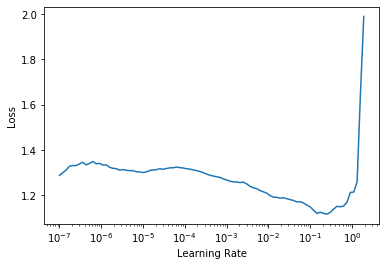

In [12]:
learn_c.lr_find()

In [13]:
lr = 3e-2
# lr *= bs/48  # Scale learning rate by batch size
n_epochs = 10
div = 10
cb = SaveModelCallback()

In [14]:
learn_c.fit_one_cycle(n_epochs, lr, wd=wd, moms=moms, div=div, cbs=cb)
learn_c.unfreeze()
lr /= 5
learn_c.fit_one_cycle(2*n_epochs, slice(lr/(2.6**4),lr), wd=wd, moms=moms, div=div, cbs=cb)

epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.774545,0.594288,0.831551,0.629767,0.596566,00:05
1,0.756287,0.578811,0.843583,0.636582,0.637181,00:05
2,0.773967,0.577433,0.843583,0.680301,0.652625,00:05
3,0.772209,0.634691,0.788770,0.536450,0.500115,00:04
4,0.772016,0.565026,0.852941,0.649353,0.669365,00:05
5,0.758186,0.573457,0.842246,0.685540,0.625810,00:06
6,0.734175,0.552872,0.847594,0.709948,0.651785,00:05
7,0.738553,0.568189,0.842246,0.639633,0.654232,00:05
8,0.725000,0.553736,0.850267,0.669766,0.646226,00:05
9,0.721040,0.555163,0.854278,0.674984,0.657809,00:05


epoch,train_loss,valid_loss,accuracy,f1_score,matthews_corrcoef,time
0,0.691590,0.537673,0.858289,0.688883,0.680261,00:13
1,0.623427,0.541088,0.860963,0.732434,0.679521,00:12
2,0.582784,0.551323,0.868984,0.747301,0.709049,00:13
3,0.560059,0.529857,0.868984,0.777059,0.715340,00:12
4,0.555078,0.534121,0.868984,0.711428,0.698575,00:14
5,0.519812,0.517178,0.862299,0.756829,0.681961,00:13
6,0.499062,0.547439,0.866310,0.701500,0.687788,00:12
7,0.485051,0.527052,0.877005,0.786955,0.721741,00:13
8,0.462428,0.540301,0.868984,0.753049,0.693810,00:12
9,0.451039,0.548413,0.875668,0.724504,0.719615,00:12


In [15]:
test_splits = RandomSplitter(0.0)(test_df)
x_tfms = [attrgetter('text'),
        Tokenizer.from_folder(path, SentencePieceTokenizer, output_dir=path, sp_model='tmp/spm.model'),
        Numericalize(vocab)]
test_dsrc = Datasets(test_df, tfms=[x_tfms, [attrgetter('label'), Categorize()]], splits=test_splits, dl_type=SortedDL)
test_data = test_dsrc.dataloaders(bs=bs, before_batch=pad_input_chunk, seq_len=seq_len,
                                  cache=2048, num_workers=8, pin_memory=True)
learn_c.validate(dl=test_data[0])

(#4) [0.5145070552825928,0.8912466764450073,0.6328188053459017,0.6706091796543721]

In [16]:
#[0.5145070552825928,0.8912466764450073,0.6328188053459017,0.6706091796543721]
# learn_c.save(f'{lang}clas_{tok}_{data_format}_fwd')

In [17]:
from fastai2.interpret import *
interp = ClassificationInterpretation.from_learner(learn_c)
interp.plot_top_losses(10)

,input,target,predicted,probability,loss
0,▁xxbos ▁בהצלחה ▁( ▁וה קיים ▁ב אבד ון ▁),1,0,0.9502453207969666,3.6121597290039062
1,▁xxbos ▁רובי ▁ריבלין ▁הוא ▁נשיא ▁של ▁מדינת ▁כל ▁אויבי ה ▁.,1,0,0.9172863960266113,2.974113702774048
2,"▁xxbos ▁קר יק טור ה ▁פר י ▁ע טו ▁של ▁בן ▁המשפחה ▁, ▁ה עיתונאי ▁וה קר יק טור יסט ▁רע נן ▁ל ורי א",1,0,0.6412240862846375,2.8566179275512695
3,▁xxbos ▁יום ▁עצוב ▁ למוסד ▁הנשיאות ▁ולמדינה ▁.,1,0,0.9208645224571228,2.781691312789917
4,▁xxbos ▁ידעתי ▁ש כש ריבלין ▁יהיה ▁נשיא ▁הוא ▁ ית קלקל ▁לנו ▁. ▁חבל ▁!,1,0,0.9113596677780151,2.7490570545196533
5,▁xxbos ▁נשיא ▁מדינת ▁ישראל xxunk,1,0,0.8963759541511536,2.736593008041382
6,▁xxbos ▁מאוכזב ▁ממך ▁אדוני ▁הנשיא ▁!,1,0,0.8853574991226196,2.473942279815674
7,▁xxbos ▁אדוני ▁הנשיא ▁הנבחר ▁אולי ▁ת תייחס ▁סוף ▁סוף,1,0,0.879170298576355,2.4680845737457275
8,▁xxbos ▁רובי ▁היקר xxunk ▁הקריא ה ▁שצריכ ה ▁ל צאת ▁היא ▁דבר ▁אחד ▁קטן ▁ל יתן ▁ פסק י ▁ דין ▁מוות ▁למחבלים xxunk ▁שיהי ו ▁שה יד ים ▁ו הרבה ▁שה יד ים ▁אבל ▁שיהי ו ▁מת ים ▁את ▁גופ ת יהם ▁יש ▁ל עט וף ▁ב עור ▁של ▁חז יר ▁ואת ▁ע פר ▁גופ ם ▁יש ▁ל ז רוק ▁ל ים xxunk ▁ככה ▁ נהג ה ▁או מה ▁אח ת ▁ש שלט ה ▁בארץ ▁ולא ומה ▁הזו ▁ קרא ו ▁ אנגלי ה ▁אז ▁אם ▁להם ▁היה ▁מותר ▁מ דוע ▁לנו ▁אסור ▁? ▁... xxunk ▁א שמח ▁על ▁ תשובה ▁ממך ▁xxrep ▁3 ▁!,0,1,0.825160026550293,2.370262861251831
9,▁xxbos ▁. ▁דוד ו ▁ אין ▁כמוך ▁בעולם,2,0,0.8862964510917664,2.360097885131836


In [18]:
train_df.iloc[splits[1]].iloc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

,text,label,is_valid
1648,בהצלחה ( והקיים באבדון ),1,False
3409,רובי ריבלין הוא נשיא של מדינת כל אויביה .,1,False
388,"קריקטורה פרי עטו של בן המשפחה , העיתונאי והקריקטוריסט רענן לוריא",1,False
103,יום עצוב למוסד הנשיאות ולמדינה .,1,False
3018,ידעתי שכשריבלין יהיה נשיא הוא יתקלקל לנו . חבל !,1,False
174,נשיא מדינת ישראל תתבייש,1,False
4306,מאוכזב ממך אדוני הנשיא !,1,False
7199,אדוני הנשיא הנבחר אולי תתייחס סוף סוף,1,False
7017,רובי היקר .... הקריאה שצריכה לצאת היא דבר אחד קטן ליתן פסקי דין מוות למחבלים ..... שיהיו שהידים והרבה שהידים אבל שיהיו מתים את גופתיהם יש לעטוף בעור של חזיר ואת עפר גופם יש לזרוק לים ..... ככה נהגה אומה אחת ששלטה בארץ ולאומה הזו קראו אנגליה אז אם להם היה מותר מדוע לנו אסור ?....... אשמח על תשובה ממך !!!,0,False
6400,. דודו אין כמוך בעולם,2,False


In [19]:
#test.loc[np.array(interp.dl.get_idxs())[interp.top_losses(k=10)[1]]]

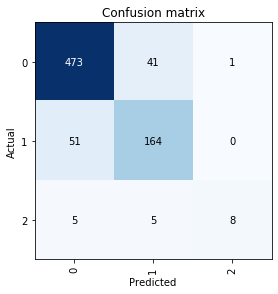

In [20]:
interp.plot_confusion_matrix()

In [21]:
# 0 - positive
# 1 - negative
# 2 - neutral